In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from torch.nn import functional as F
import configparser
import pandas as pd 

import numpy as np
import torch
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from os.path import join as oj
sys.path.insert(0, "../src")
from unet import UNet
import my_data
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
fig_path =config['PATHS']['figure_path'] 


In [12]:
# need exp with no active learning
# need exp with prop increasingf
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects()


results.reset_index(inplace=True)
results = results[results.add_ratio <=.1]
results[['foldername',  'cost_function', 'add_ratio',  'test_dice_score', 
         'experiment_name']].groupby([ 'experiment_name', 'cost_function','add_ratio', 
         'foldername' ]).mean()



test_dice_score
experiment_name     cost_function add_ratio foldername                   
AActiveLearning     cut_off_cost  0.040     lno_halfHour            0.955
BNoActiveLearning   random_cost   0.000     lno_halfHour            0.876
FActiveLearning     cut_off_cost  0.020     lno_halfHour            0.955
                                  0.040     lno_halfHour            0.957
                                  0.060     lno_halfHour            0.960
                                  0.080     lno_halfHour            0.959
                                  0.100     lno_halfHour            0.962
                    emc           0.020     lno_halfHour            0.945
                                  0.040     lno_halfHour            0.954
                                  0.060     lno_halfHour            0.962
                                  0.080     lno_halfHour            0.963
                                  0.100     lno_halfHour            0.959
                    random_cost   0.020     lno_halfHour            0.943
                                  0.040     lno_halfHour            0.951
                                  0.060     lno_halfHour            0.956
                                  0.080     lno_halfHour            0.952
                                  0.100     lno_halfHour            0.958
FullDatasetTraining random_cost   0.000     lno                     0.968
LActiveLearning     cut_off_cost  0.020     lno_halfHour            0.952
                                  0.040     lno_halfHour            0.958

In [7]:
results = results[results.cost_function != 'emc']

In [8]:
# lr_results = results[results['experiment_name'] == 'LearningRate']
# # lr = lr[]
# results[results['experiment_name'] == 'LearningRate'][['lr', 'test_dice_score']].groupby(['lr', ]).mean()

# a = results[results['experiment_name'] == 'LearningRate'][['lr', 'test_dice_score']].groupby(['lr', ]).mean()
# b = results[results['experiment_name'] == 'LearningRate'][['lr', 'test_dice_score']].groupby(['lr', ]).std()
# # plot this data with mean and std

# # x axis as log
# plt.figure(figsize=(5,5))
# plt.xscale('log')
# plt.errorbar(a.index, a.test_dice_score, b.test_dice_score, linestyle='None', marker='^')
# plt.ylabel('Dice Score', fontsize =25)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.xlabel('Learning Rate', fontsize =25)
# plt.tight_layout()
# plt.savefig(oj(fig_path, 'lr.png'))


C:\Users\lauri\AppData\Local\Temp\ipykernel_11604\2398280566.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_dict['Random'] = results[results.experiment_name == 'FActiveLearning'][results.cost_function == 'random_cost'][results.add_ratio == .04].test_dice_score
C:\Users\lauri\AppData\Local\Temp\ipykernel_11604\2398280566.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_dict['Random'] = results[results.experiment_name == 'FActiveLearning'][results.cost_function == 'random_cost'][results.add_ratio == .04].test_dice_score
C:\Users\lauri\AppData\Local\Temp\ipykernel_11604\2398280566.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_dict['Active Learning'] = results[results.experiment_name == 'FActiveLearning'][results.cost_function == 'cut_off_cost'][results.add_ratio == .04].test_dice_score
C:\Users\lauri\AppData\Local\Temp\ipykernel_11604\2398280566.py:7: UserW

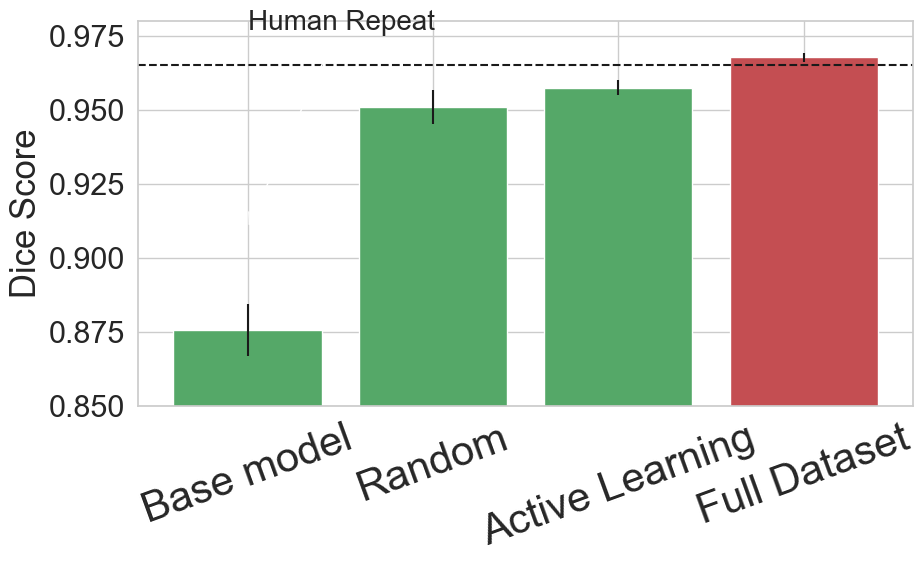

In [13]:
# make figure barplot
results_dict ={}
results_dict['Base model'] = results[results.experiment_name == 'BNoActiveLearning'].test_dice_score
results_dict['Random'] = results[results.experiment_name == 'FActiveLearning'][results.cost_function == 'random_cost'][results.add_ratio == .04].test_dice_score

# results_dict['EMC'] = results[results.experiment_name == 'FActiveLearning'][results.cost_function == 'emc'][results.add_ratio == .04].test_dice_score
results_dict['Active Learning'] = results[results.experiment_name == 'FActiveLearning'][results.cost_function == 'cut_off_cost'][results.add_ratio == .04].test_dice_score
results_dict['Full Dataset'] = results[results.experiment_name == 'FullDatasetTraining'].test_dice_score
# results_dict['Human repeat'] = np.asarray([0.9761262536048889])
for key in results_dict:
    results_dict[key] = np.asarray(results_dict[key])
# make barplot
plt.figure(figsize=(10,5))
plt.bar(results_dict.keys(), 
        [np.mean(results_dict[key]) for key in results_dict.keys()], 
        yerr=[np.std(results_dict[key])/np.sqrt(len(results_dict[key])) for key in results_dict.keys()],
        # color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        color = ['g', 'g','g', 'r','g',])


plt.xticks(fontsize=30, rotation=20)
# plt.yticks([ 0.94, 0.96,  0.98], fontsize=20)
plt.axhline(0.965, color='k', linestyle='--', label ='Human Repeat',)
# an arrow that points to the human repeat score and says "human repeat"
plt.annotate('Human Repeat', xy=(0, 0.91), xytext=(0, 0.977), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=20)

plt.ylim(0.85, 0.98)
plt.ylabel('Dice Score', fontsize=25)

# plt.legend(loc = 'center left', fontsize=20) 
plt.savefig(oj(fig_path, 'results_dice.pdf'), dpi=300, bbox_inches='tight')

C:\Users\lauri\AppData\Local\Temp\ipykernel_11604\4001605100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_here_copy.cost_function = 'cut_off_cost'
C:\Users\lauri\AppData\Local\Temp\ipykernel_11604\4001605100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_here_copy.cost_function = 'random_cost'
C:\Users\lauri\AppData\Local\Temp\ipykernel_11604\4001605100.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

<Figure size 1000x500 with 0 Axes>

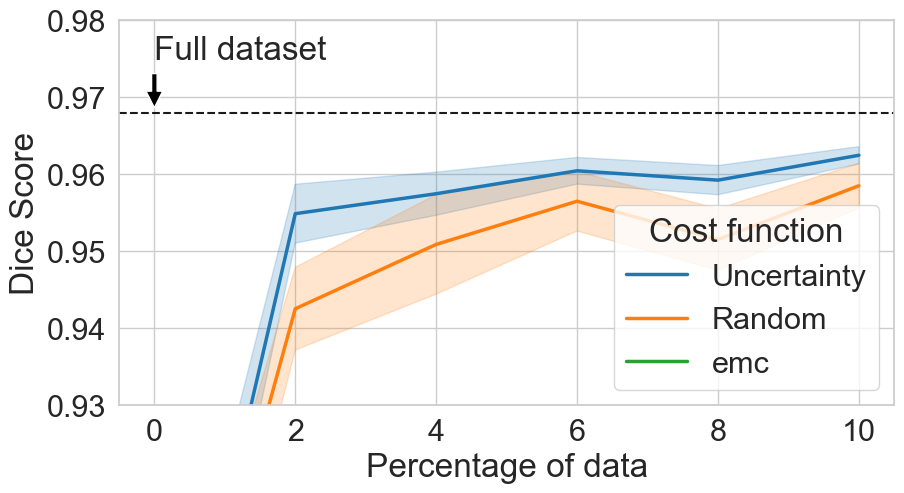

In [10]:
import seaborn as sns
#lineplot
results_here = results[results.experiment_name == 'FActiveLearning']

results_here_copy = results[results.experiment_name == 'BNoActiveLearning']
results_here_copy.cost_function = 'cut_off_cost'
results_here = pd.concat([results_here, results_here_copy])
results_here_copy = results[results.experiment_name == 'BNoActiveLearning']
results_here_copy.cost_function = 'random_cost'
results_here = pd.concat([results_here, results_here_copy])
results_here_copy = results[results.experiment_name == 'BNoActiveLearning']
results_here_copy.cost_function = 'emc'
results_here = pd.concat([results_here, results_here_copy])



plt.figure(figsize=(10,5))
#rename 
results_here.cost_function = results_here.cost_function.replace('cut_off_cost', 'Uncertainty')
results_here.cost_function = results_here.cost_function.replace('random_cost', 'Random')
#make matplotlib
# results_here = results_here[results_here.add_ratio < .1]
plt.figure(figsize=(10,5))

#rename column
results_here = results_here.rename(columns={'test_dice_score': 'Dice Score'})
results_here.add_ratio = results_here.add_ratio*100
results_here = results_here.rename (columns={'add_ratio': 'Percentage of data'})

results_here = results_here.rename(columns={'cost_function': 'Cost function'})
# results_here = results_here.rename(columns={'add_ratio': '% of Dataset'})

#increase font size for seaborm
sns.set(font_scale=2)
sns.set_style("whitegrid")
# sns.despine(offset=10, trim=True);
# g_results = sns.lineplot(data=results_here, x="% of Dataset", y="Dice Score", hue="Cost function", errorbar='se', palette="tab10", linewidth=2.5)

g_results = sns.lineplot(data=results_here, x="Percentage of data", y="Dice Score", hue="Cost function", errorbar='se', palette="tab10", linewidth=2.5)

plt.ylim(.93, .98)
plt.axhline(0.968, color='k', linestyle='--', label ='Full dataset',)
# an arrow that points to the h line and says "Full dataset"
plt.annotate('Full dataset', xy=(0, 0.968), xytext=(0, 0.975), arrowprops=dict(facecolor='black', shrink=0.1),)
# savefig
plt.savefig(oj(fig_path, 'results_lineplot.pdf'), dpi=300, bbox_inches='tight')